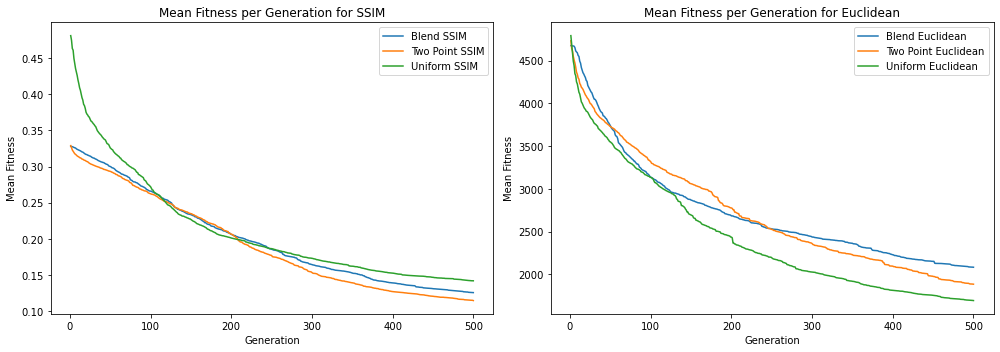

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def process_fitness_file(filename):
    with open(filename, "r") as file:
        fitness_values = [float(line.strip()) for line in file]

    num_generations_per_run = 500
    num_runs = len(fitness_values) // num_generations_per_run

    fitness_values = np.array(fitness_values)
    fitness_values = fitness_values.reshape(num_runs, num_generations_per_run)
    
    mean_fitness_per_generation = np.mean(fitness_values, axis=0)
    
    return mean_fitness_per_generation

mean_fitness_blend_ssim = process_fitness_file("fitness_values_blend.txt")
mean_fitness_blend_euclidean = process_fitness_file("fitness_values_euclidean_blend.txt")

mean_fitness_2PC_ssim = process_fitness_file("fitness_values_2PC.txt")
mean_fitness_2PC_euclidean = process_fitness_file("fitness_values_euclidean.txt")

mean_fitness_uniform_ssim = process_fitness_file("fitness_values_uniform.txt")
mean_fitness_uniform_euclidean = process_fitness_file("fitness_values_euclidean_uniform.txt")

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot SSIM curves in the first subplot
axs[0].plot(range(1, 501), mean_fitness_blend_ssim, label='Blend SSIM')
axs[0].plot(range(1, 501), mean_fitness_2PC_ssim, label='Two Point SSIM')
axs[0].plot(range(1, 501), mean_fitness_uniform_ssim, label='Uniform SSIM')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Mean Fitness')
axs[0].set_title('Mean Fitness per Generation for SSIM')
axs[0].legend()

# Plot Euclidean curves in the second subplot
axs[1].plot(range(1, 501), mean_fitness_blend_euclidean, label='Blend Euclidean')
axs[1].plot(range(1, 501), mean_fitness_2PC_euclidean, label='Two Point Euclidean')
axs[1].plot(range(1, 501), mean_fitness_uniform_euclidean, label='Uniform Euclidean')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Mean Fitness')
axs[1].set_title('Mean Fitness per Generation for Euclidean')
axs[1].legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [1]:
import matplotlib.pyplot as plt
import random
from PIL import Image, ImageDraw
import numpy as np
from skimage.metrics import structural_similarity as ssim
from copy import deepcopy
from sklearn.cluster import KMeans
import cv2

# Grid Search 

In [2]:
class Color:
    def __init__(self, filename, num_colors=10):
        self.target_image = cv2.imread(filename)
        self.target_image = cv2.cvtColor(self.target_image, cv2.COLOR_BGR2RGB)
        self.height, self.width, _ = self.target_image.shape
        self.palette = self.extract_palette(self.target_image, num_colors).astype(int)
        print("Extracted palette:", self.palette)

    def extract_palette(self, image, num_colors=10):
        pixels = image.reshape((-1, 3))
        kmeans = KMeans(n_clusters=num_colors)
        kmeans.fit(pixels)
        palette = kmeans.cluster_centers_
        return palette

class Triangle:
    def __init__(self, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.palette = palette
        x = random.randint(0, img_width)
        y = random.randint(0, img_height)

        self.points = [
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50)),
            (x + random.randint(-50, 50), y + random.randint(-50, 50))
        ]
        self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))

    def mutate(self, mutation_rate=0.01):
        if random.random() < mutation_rate:
            mutation_type = random.choice(['shift', 'point', 'color', 'swap'])
            if mutation_type == 'shift':
                self.points = [(x + random.randint(-50, 50), y + random.randint(-50, 50)) for x, y in self.points]
            elif mutation_type == 'point':
                index = random.choice(range(3))
                self.points[index] = (self.points[index][0] + random.randint(-50, 50), self.points[index][1] + random.randint(-50, 50))
            elif mutation_type == 'color':
                self.color = tuple(self.palette[random.randint(0, len(self.palette) - 1)].astype(int))
            elif mutation_type == 'swap':
                i, j = random.sample(range(3), 2)
                self.points[i], self.points[j] = self.points[j], self.points[i]

class Painting:
    def __init__(self, num_triangles, img_width, img_height, palette):
        self._img_width = img_width
        self._img_height = img_height
        self.triangles = [Triangle(img_width, img_height, palette) for _ in range(num_triangles)]

    def draw(self) -> Image:
        image = Image.new("RGB", (self._img_width, self._img_height), (255, 255, 255))
        draw = ImageDraw.Draw(image)
        for t in self.triangles:
            draw.polygon(t.points, fill=t.color)
        return image

    def mutate(self, mutation_rate=0.01):
        for triangle in self.triangles:
            triangle.mutate(mutation_rate)

def calculate_fitness(painting, target_image):
    target_array = np.array(target_image)
    rendered_image = np.array(painting.draw())
    # Calculate the Euclidean distance
    distance = np.sqrt(np.sum((target_array - rendered_image) ** 2))
    return distance

def uniform_crossover(parent1, parent2, crossover_prob=0.5):
    child1 = deepcopy(parent1)
    child2 = deepcopy(parent2)

    for i in range(len(parent1.triangles)):
        if random.random() < crossover_prob:
            child1.triangles[i], child2.triangles[i] = child2.triangles[i], child1.triangles[i]

    return child1, child2

class Population:
    def __init__(self, size, img_width, img_height, num_triangles, target_image, palette):
        self.size = size
        self.img_width = img_width
        self.img_height = img_height
        self.num_triangles = num_triangles
        self.target_image = target_image
        self.palette = palette
        self.individuals = [Painting(num_triangles, img_width, img_height, palette) for _ in range(size)]
        self.fitness = [calculate_fitness(ind, target_image) for ind in self.individuals]
        self.fitness_history = []

    def evolve(self, gens, xo_prob, mut_prob, elitism):
        for gen in range(gens):
            new_pop = []
            if elitism:
                elite = deepcopy(self.individuals[self.fitness.index(min(self.fitness))])

            while len(new_pop) < self.size:
                parent1 = self.tournament_selection()
                parent2 = self.tournament_selection()

                if random.random() < xo_prob:
                    child1, child2 = uniform_crossover(parent1, parent2)
                else:
                    child1, child2 = deepcopy(parent1), deepcopy(parent2)

                child1.mutate(mut_prob)
                child2.mutate(mut_prob)

                new_pop.extend([child1, child2])

            if elitism:
                worst_index = self.fitness.index(max(self.fitness))
                new_pop[worst_index] = elite

            self.individuals = new_pop[:self.size]
            self.fitness = [calculate_fitness(ind, self.target_image) for ind in self.individuals]
            self.fitness_history.append(min(self.fitness))

            print(f"Generation {gen + 1}, Best Fitness: {min(self.fitness)}")

    def tournament_selection(self, k=3):
        selected = random.sample(list(zip(self.individuals, self.fitness)), k)
        return min(selected, key=lambda x: x[1])[0]

Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [ 86  86  86]
 [182 182 182]
 [119  66   0]
 [ 41  36  31]
 [136 136 136]
 [222 222 222]
 [223 123   0]]
Generation 1, Best Fitness: 4537.2098254323655
Generation 2, Best Fitness: 4537.2098254323655
Generation 3, Best Fitness: 4446.638505657954
Generation 4, Best Fitness: 4414.875989198337
Generation 5, Best Fitness: 4414.463727339936
Generation 6, Best Fitness: 4289.26392286602
Generation 7, Best Fitness: 4195.549666015169
Generation 8, Best Fitness: 4158.927265533745
Generation 9, Best Fitness: 4141.197773591597
Generation 10, Best Fitness: 4059.2932882461205
Generation 11, Best Fitness: 4056.390020695742
Generation 12, Best Fitness: 4005.419328859339
Generation 13, Best Fitness: 3968.0026461684724
Generation 14, Best Fitness: 3948.40474115813
Generation 15, Best Fitness: 3868.8686976944564
Generation 16, Best Fitness: 3868.8686976944564
Generation 17, Best Fitness: 3858.4448939955073
Generation 18, Best Fitness: 3826.8

Generation 170, Best Fitness: 2919.472726366869
Generation 171, Best Fitness: 2918.924116862239
Generation 172, Best Fitness: 2917.2978935994865
Generation 173, Best Fitness: 2915.58844832394
Generation 174, Best Fitness: 2915.4917252497903
Generation 175, Best Fitness: 2913.3073988166784
Generation 176, Best Fitness: 2911.721655653232
Generation 177, Best Fitness: 2911.289405057491
Generation 178, Best Fitness: 2909.856182013125
Generation 179, Best Fitness: 2906.5611983923545
Generation 180, Best Fitness: 2890.7780959457955
Generation 181, Best Fitness: 2890.5855808123033
Generation 182, Best Fitness: 2883.952496141363
Generation 183, Best Fitness: 2881.165215672298
Generation 184, Best Fitness: 2873.944153945932
Generation 185, Best Fitness: 2871.0299545633443
Generation 186, Best Fitness: 2865.5172307979583
Generation 187, Best Fitness: 2860.4036428448344
Generation 188, Best Fitness: 2860.317290092132
Generation 189, Best Fitness: 2858.0248424392676
Generation 190, Best Fitness: 2

Generation 339, Best Fitness: 2287.424097101366
Generation 340, Best Fitness: 2286.904676631713
Generation 341, Best Fitness: 2286.904676631713
Generation 342, Best Fitness: 2285.8657003419953
Generation 343, Best Fitness: 2285.8657003419953
Generation 344, Best Fitness: 2285.527291458144
Generation 345, Best Fitness: 2283.2691475163415
Generation 346, Best Fitness: 2282.6506522023906
Generation 347, Best Fitness: 2281.9890446713366
Generation 348, Best Fitness: 2281.7883337417607
Generation 349, Best Fitness: 2281.372613143237
Generation 350, Best Fitness: 2281.372613143237
Generation 351, Best Fitness: 2281.071677961918
Generation 352, Best Fitness: 2280.6422341086295
Generation 353, Best Fitness: 2258.3186223383095
Generation 354, Best Fitness: 2257.976084904355
Generation 355, Best Fitness: 2257.5065891376707
Generation 356, Best Fitness: 2257.2162058606614
Generation 357, Best Fitness: 2256.532960096085
Generation 358, Best Fitness: 2256.168876657951
Generation 359, Best Fitness: 

Generation 7, Best Fitness: 4368.106912611
Generation 8, Best Fitness: 4311.390842871938
Generation 9, Best Fitness: 4235.523108188645
Generation 10, Best Fitness: 4167.843567121971
Generation 11, Best Fitness: 4167.843567121971
Generation 12, Best Fitness: 4091.7564688040757
Generation 13, Best Fitness: 4078.093304474531
Generation 14, Best Fitness: 4061.9098956032985
Generation 15, Best Fitness: 4046.0048195720183
Generation 16, Best Fitness: 3989.296429196507
Generation 17, Best Fitness: 3989.296429196507
Generation 18, Best Fitness: 3989.296429196507
Generation 19, Best Fitness: 3949.7268259969574
Generation 20, Best Fitness: 3949.628083756748
Generation 21, Best Fitness: 3936.691250276049
Generation 22, Best Fitness: 3935.175218462324
Generation 23, Best Fitness: 3927.702127198548
Generation 24, Best Fitness: 3926.4298032691227
Generation 25, Best Fitness: 3919.8406855381254
Generation 26, Best Fitness: 3916.6656737587396
Generation 27, Best Fitness: 3901.5563561225154
Generation 

Generation 179, Best Fitness: 2670.8854337092034
Generation 180, Best Fitness: 2662.735060046343
Generation 181, Best Fitness: 2658.837339891254
Generation 182, Best Fitness: 2658.837339891254
Generation 183, Best Fitness: 2651.726607325876
Generation 184, Best Fitness: 2650.5556021332586
Generation 185, Best Fitness: 2594.8454674604423
Generation 186, Best Fitness: 2592.786339056884
Generation 187, Best Fitness: 2591.5273488813505
Generation 188, Best Fitness: 2544.8929250559836
Generation 189, Best Fitness: 2544.43490779387
Generation 190, Best Fitness: 2536.4232690937056
Generation 191, Best Fitness: 2534.0546560798566
Generation 192, Best Fitness: 2493.211382935671
Generation 193, Best Fitness: 2488.888105158607
Generation 194, Best Fitness: 2488.261843134681
Generation 195, Best Fitness: 2472.9021412097973
Generation 196, Best Fitness: 2472.9021412097973
Generation 197, Best Fitness: 2472.9021412097973
Generation 198, Best Fitness: 2471.8600283996666
Generation 199, Best Fitness: 

Generation 348, Best Fitness: 2006.7381493358819
Generation 349, Best Fitness: 2006.7381493358819
Generation 350, Best Fitness: 1997.9672169482662
Generation 351, Best Fitness: 1997.207800906055
Generation 352, Best Fitness: 1996.5913452682298
Generation 353, Best Fitness: 1996.5913452682298
Generation 354, Best Fitness: 1995.8061028065827
Generation 355, Best Fitness: 1995.8061028065827
Generation 356, Best Fitness: 1993.8512983670573
Generation 357, Best Fitness: 1992.749607953794
Generation 358, Best Fitness: 1992.749607953794
Generation 359, Best Fitness: 1976.9370247936579
Generation 360, Best Fitness: 1976.9370247936579
Generation 361, Best Fitness: 1976.3876138045391
Generation 362, Best Fitness: 1975.4052748739941
Generation 363, Best Fitness: 1974.2150338805548
Generation 364, Best Fitness: 1972.5709112729003
Generation 365, Best Fitness: 1972.5085551145273
Generation 366, Best Fitness: 1969.3630950132076
Generation 367, Best Fitness: 1969.3630950132076
Generation 368, Best Fi

Generation 16, Best Fitness: 3876.665577529225
Generation 17, Best Fitness: 3875.9222128417387
Generation 18, Best Fitness: 3875.3278570980287
Generation 19, Best Fitness: 3835.1383286656037
Generation 20, Best Fitness: 3835.1383286656037
Generation 21, Best Fitness: 3819.189180964986
Generation 22, Best Fitness: 3794.7515070159734
Generation 23, Best Fitness: 3794.7515070159734
Generation 24, Best Fitness: 3794.5080049988037
Generation 25, Best Fitness: 3784.9066038675246
Generation 26, Best Fitness: 3781.80552117636
Generation 27, Best Fitness: 3752.0263858347266
Generation 28, Best Fitness: 3752.0263858347266
Generation 29, Best Fitness: 3739.315846515242
Generation 30, Best Fitness: 3733.4422454351693
Generation 31, Best Fitness: 3695.107711555916
Generation 32, Best Fitness: 3657.2177949911597
Generation 33, Best Fitness: 3657.2177949911597
Generation 34, Best Fitness: 3642.254933416935
Generation 35, Best Fitness: 3607.593103441684
Generation 36, Best Fitness: 3607.593103441684
G

Generation 187, Best Fitness: 2472.6558595971255
Generation 188, Best Fitness: 2462.4583245204376
Generation 189, Best Fitness: 2459.6430635358456
Generation 190, Best Fitness: 2459.6186696315344
Generation 191, Best Fitness: 2459.6125711176546
Generation 192, Best Fitness: 2458.9237483094103
Generation 193, Best Fitness: 2457.7272021117396
Generation 194, Best Fitness: 2456.232277289752
Generation 195, Best Fitness: 2453.9032173254104
Generation 196, Best Fitness: 2451.6404711947466
Generation 197, Best Fitness: 2451.6404711947466
Generation 198, Best Fitness: 2451.210517275087
Generation 199, Best Fitness: 2446.9252134055914
Generation 200, Best Fitness: 2446.9252134055914
Generation 201, Best Fitness: 2436.92675310523
Generation 202, Best Fitness: 2435.7785203092667
Generation 203, Best Fitness: 2435.7785203092667
Generation 204, Best Fitness: 2434.084222043272
Generation 205, Best Fitness: 2434.084222043272
Generation 206, Best Fitness: 2434.084222043272
Generation 207, Best Fitnes

Generation 356, Best Fitness: 1858.8028405401149
Generation 357, Best Fitness: 1857.6571265979092
Generation 358, Best Fitness: 1857.140005492316
Generation 359, Best Fitness: 1857.140005492316
Generation 360, Best Fitness: 1856.1314608615414
Generation 361, Best Fitness: 1856.126881438874
Generation 362, Best Fitness: 1855.146355412424
Generation 363, Best Fitness: 1855.146355412424
Generation 364, Best Fitness: 1854.0916913680403
Generation 365, Best Fitness: 1854.0916913680403
Generation 366, Best Fitness: 1853.8602967861414
Generation 367, Best Fitness: 1853.1934599496083
Generation 368, Best Fitness: 1853.0253641005565
Generation 369, Best Fitness: 1852.1644095490012
Generation 370, Best Fitness: 1852.1644095490012
Generation 371, Best Fitness: 1852.1644095490012
Generation 372, Best Fitness: 1850.9324677037787
Generation 373, Best Fitness: 1844.7853533677028
Generation 374, Best Fitness: 1844.7853533677028
Generation 375, Best Fitness: 1844.6812732827316
Generation 376, Best Fitn

Generation 24, Best Fitness: 3702.3092793552514
Generation 25, Best Fitness: 3702.3092793552514
Generation 26, Best Fitness: 3702.24431932848
Generation 27, Best Fitness: 3688.5117595040956
Generation 28, Best Fitness: 3683.1337200813114
Generation 29, Best Fitness: 3656.71341507644
Generation 30, Best Fitness: 3643.373025096387
Generation 31, Best Fitness: 3594.9806675418995
Generation 32, Best Fitness: 3580.744894571519
Generation 33, Best Fitness: 3570.458093858546
Generation 34, Best Fitness: 3556.3426437844823
Generation 35, Best Fitness: 3549.8723920727066
Generation 36, Best Fitness: 3515.407088802092
Generation 37, Best Fitness: 3515.407088802092
Generation 38, Best Fitness: 3508.008409339978
Generation 39, Best Fitness: 3497.4289127872207
Generation 40, Best Fitness: 3482.465218778215
Generation 41, Best Fitness: 3472.20707907809
Generation 42, Best Fitness: 3439.6319570558708
Generation 43, Best Fitness: 3439.6319570558708
Generation 44, Best Fitness: 3415.3040860222095
Gener

Generation 195, Best Fitness: 2111.91997954468
Generation 196, Best Fitness: 2103.7480837780936
Generation 197, Best Fitness: 2102.7210942015113
Generation 198, Best Fitness: 2102.7210942015113
Generation 199, Best Fitness: 2101.0752009387957
Generation 200, Best Fitness: 2101.0752009387957
Generation 201, Best Fitness: 2100.9138487810487
Generation 202, Best Fitness: 2099.902140577032
Generation 203, Best Fitness: 2098.8823216178653
Generation 204, Best Fitness: 2098.8823216178653
Generation 205, Best Fitness: 2080.545841840549
Generation 206, Best Fitness: 2078.0981689997225
Generation 207, Best Fitness: 2078.0122713785886
Generation 208, Best Fitness: 2077.2811557418026
Generation 209, Best Fitness: 2070.3951313698553
Generation 210, Best Fitness: 2070.3951313698553
Generation 211, Best Fitness: 2052.860930506497
Generation 212, Best Fitness: 2052.860930506497
Generation 213, Best Fitness: 2052.860930506497
Generation 214, Best Fitness: 2044.183210967158
Generation 215, Best Fitness

Generation 364, Best Fitness: 1815.8827054631033
Generation 365, Best Fitness: 1815.8827054631033
Generation 366, Best Fitness: 1814.7765702697398
Generation 367, Best Fitness: 1810.791539631219
Generation 368, Best Fitness: 1808.2505357388948
Generation 369, Best Fitness: 1807.8077884553988
Generation 370, Best Fitness: 1806.512109010067
Generation 371, Best Fitness: 1805.2617538739362
Generation 372, Best Fitness: 1805.2617538739362
Generation 373, Best Fitness: 1804.679472925871
Generation 374, Best Fitness: 1803.5315356266992
Generation 375, Best Fitness: 1802.8283334804787
Generation 376, Best Fitness: 1801.954216954471
Generation 377, Best Fitness: 1801.1732287595216
Generation 378, Best Fitness: 1800.3124728779724
Generation 379, Best Fitness: 1800.28331103746
Generation 380, Best Fitness: 1800.28331103746
Generation 381, Best Fitness: 1799.3546065186817
Generation 382, Best Fitness: 1799.219830926727
Generation 383, Best Fitness: 1798.4826938283281
Generation 384, Best Fitness:

Generation 32, Best Fitness: 4028.722626342002
Generation 33, Best Fitness: 4021.276538613081
Generation 34, Best Fitness: 3990.71660231593
Generation 35, Best Fitness: 3969.311779137537
Generation 36, Best Fitness: 3969.311779137537
Generation 37, Best Fitness: 3920.851565667846
Generation 38, Best Fitness: 3920.851565667846
Generation 39, Best Fitness: 3914.380793944299
Generation 40, Best Fitness: 3884.932174440115
Generation 41, Best Fitness: 3850.0148051663386
Generation 42, Best Fitness: 3846.349178116828
Generation 43, Best Fitness: 3829.9610964081608
Generation 44, Best Fitness: 3824.5708255959908
Generation 45, Best Fitness: 3807.78058716623
Generation 46, Best Fitness: 3807.78058716623
Generation 47, Best Fitness: 3807.78058716623
Generation 48, Best Fitness: 3797.0043455334626
Generation 49, Best Fitness: 3796.933367864124
Generation 50, Best Fitness: 3775.649083270319
Generation 51, Best Fitness: 3769.960875128547
Generation 52, Best Fitness: 3769.960875128547
Generation 53

Generation 203, Best Fitness: 2566.844950518048
Generation 204, Best Fitness: 2545.196848968661
Generation 205, Best Fitness: 2540.3052966129876
Generation 206, Best Fitness: 2540.012401544528
Generation 207, Best Fitness: 2524.419537240195
Generation 208, Best Fitness: 2524.419537240195
Generation 209, Best Fitness: 2492.4146926223975
Generation 210, Best Fitness: 2479.3315631435826
Generation 211, Best Fitness: 2466.6949547927484
Generation 212, Best Fitness: 2465.895172143374
Generation 213, Best Fitness: 2459.445059357903
Generation 214, Best Fitness: 2457.5833658291226
Generation 215, Best Fitness: 2433.5022087518228
Generation 216, Best Fitness: 2433.5022087518228
Generation 217, Best Fitness: 2431.556497390098
Generation 218, Best Fitness: 2427.8325724810597
Generation 219, Best Fitness: 2424.795867696908
Generation 220, Best Fitness: 2418.813345423743
Generation 221, Best Fitness: 2418.0800234897106
Generation 222, Best Fitness: 2409.6545395554112
Generation 223, Best Fitness: 

Generation 372, Best Fitness: 1962.833156434851
Generation 373, Best Fitness: 1960.4729021335643
Generation 374, Best Fitness: 1960.4729021335643
Generation 375, Best Fitness: 1959.3317738453588
Generation 376, Best Fitness: 1957.1108808649549
Generation 377, Best Fitness: 1957.1108808649549
Generation 378, Best Fitness: 1950.421236553786
Generation 379, Best Fitness: 1950.421236553786
Generation 380, Best Fitness: 1950.224089688157
Generation 381, Best Fitness: 1949.7556257131303
Generation 382, Best Fitness: 1948.1339789655126
Generation 383, Best Fitness: 1948.1339789655126
Generation 384, Best Fitness: 1946.4503589868405
Generation 385, Best Fitness: 1940.1628797603566
Generation 386, Best Fitness: 1940.1628797603566
Generation 387, Best Fitness: 1931.8278908846926
Generation 388, Best Fitness: 1931.8278908846926
Generation 389, Best Fitness: 1929.6732884092064
Generation 390, Best Fitness: 1928.3845570839858
Generation 391, Best Fitness: 1923.5222899670282
Generation 392, Best Fit

Generation 41, Best Fitness: 4048.338177573608
Generation 42, Best Fitness: 4045.372417961046
Generation 43, Best Fitness: 4038.5332733555633
Generation 44, Best Fitness: 4030.3862097818865
Generation 45, Best Fitness: 4018.6252624498343
Generation 46, Best Fitness: 4016.370376347281
Generation 47, Best Fitness: 4003.6863013977504
Generation 48, Best Fitness: 3997.2395474877408
Generation 49, Best Fitness: 3984.4758751936247
Generation 50, Best Fitness: 3982.3413967162583
Generation 51, Best Fitness: 3972.806061211647
Generation 52, Best Fitness: 3972.806061211647
Generation 53, Best Fitness: 3955.984706744959
Generation 54, Best Fitness: 3947.1873530401367
Generation 55, Best Fitness: 3942.7524649665747
Generation 56, Best Fitness: 3913.8192344562876
Generation 57, Best Fitness: 3900.011153830204
Generation 58, Best Fitness: 3896.5840168024097
Generation 59, Best Fitness: 3896.2850255082726
Generation 60, Best Fitness: 3863.5774872519382
Generation 61, Best Fitness: 3863.5774872519382

Generation 212, Best Fitness: 2848.355841533849
Generation 213, Best Fitness: 2847.9685742648217
Generation 214, Best Fitness: 2841.634036958313
Generation 215, Best Fitness: 2841.0427663095816
Generation 216, Best Fitness: 2837.8638092762662
Generation 217, Best Fitness: 2837.85482362999
Generation 218, Best Fitness: 2814.2032620263944
Generation 219, Best Fitness: 2814.2032620263944
Generation 220, Best Fitness: 2809.905692367628
Generation 221, Best Fitness: 2804.954545086248
Generation 222, Best Fitness: 2804.1827686511447
Generation 223, Best Fitness: 2801.545823291134
Generation 224, Best Fitness: 2800.745615010403
Generation 225, Best Fitness: 2785.047934955519
Generation 226, Best Fitness: 2785.047934955519
Generation 227, Best Fitness: 2784.861217367932
Generation 228, Best Fitness: 2784.6231342858587
Generation 229, Best Fitness: 2778.133366129135
Generation 230, Best Fitness: 2773.2962337262134
Generation 231, Best Fitness: 2773.2962337262134
Generation 232, Best Fitness: 27

Generation 382, Best Fitness: 2210.000226244332
Generation 383, Best Fitness: 2208.624458797828
Generation 384, Best Fitness: 2208.60815899969
Generation 385, Best Fitness: 2208.163490324029
Generation 386, Best Fitness: 2207.2523643661593
Generation 387, Best Fitness: 2207.2523643661593
Generation 388, Best Fitness: 2206.805836497629
Generation 389, Best Fitness: 2206.0598359972014
Generation 390, Best Fitness: 2206.0598359972014
Generation 391, Best Fitness: 2205.0521535782323
Generation 392, Best Fitness: 2204.6446425671415
Generation 393, Best Fitness: 2204.4820253293065
Generation 394, Best Fitness: 2203.416892011133
Generation 395, Best Fitness: 2203.416892011133
Generation 396, Best Fitness: 2201.073147353354
Generation 397, Best Fitness: 2199.788853503899
Generation 398, Best Fitness: 2199.788853503899
Generation 399, Best Fitness: 2199.788853503899
Generation 400, Best Fitness: 2198.9567981204177
Generation 401, Best Fitness: 2198.9456564453794
Generation 402, Best Fitness: 21

Generation 52, Best Fitness: 3805.7729832453224
Generation 53, Best Fitness: 3794.837545929997
Generation 54, Best Fitness: 3759.165864922696
Generation 55, Best Fitness: 3745.3852939317203
Generation 56, Best Fitness: 3743.7467863091383
Generation 57, Best Fitness: 3740.8187606458564
Generation 58, Best Fitness: 3712.1007529430017
Generation 59, Best Fitness: 3712.0126616163366
Generation 60, Best Fitness: 3708.6223857384025
Generation 61, Best Fitness: 3705.8911209046605
Generation 62, Best Fitness: 3693.809280404174
Generation 63, Best Fitness: 3688.136792473945
Generation 64, Best Fitness: 3681.816127945555
Generation 65, Best Fitness: 3677.196078535927
Generation 66, Best Fitness: 3672.638424892927
Generation 67, Best Fitness: 3672.638424892927
Generation 68, Best Fitness: 3657.4012631922137
Generation 69, Best Fitness: 3638.6755832307995
Generation 70, Best Fitness: 3625.699794522431
Generation 71, Best Fitness: 3621.290239679775
Generation 72, Best Fitness: 3598.668642706633
Gen

Generation 222, Best Fitness: 2271.064508110679
Generation 223, Best Fitness: 2271.064508110679
Generation 224, Best Fitness: 2268.085536305895
Generation 225, Best Fitness: 2261.4840260324636
Generation 226, Best Fitness: 2261.1034916606536
Generation 227, Best Fitness: 2245.41087554149
Generation 228, Best Fitness: 2244.619344120513
Generation 229, Best Fitness: 2241.2855685967374
Generation 230, Best Fitness: 2240.0662936618637
Generation 231, Best Fitness: 2238.0158623209086
Generation 232, Best Fitness: 2238.0158623209086
Generation 233, Best Fitness: 2238.0158623209086
Generation 234, Best Fitness: 2238.0158623209086
Generation 235, Best Fitness: 2234.3553880258173
Generation 236, Best Fitness: 2229.6910099832216
Generation 237, Best Fitness: 2229.6910099832216
Generation 238, Best Fitness: 2228.0013464986955
Generation 239, Best Fitness: 2221.4808124312035
Generation 240, Best Fitness: 2219.549278569863
Generation 241, Best Fitness: 2212.924761486481
Generation 242, Best Fitness

Generation 391, Best Fitness: 1876.7919437167243
Generation 392, Best Fitness: 1876.7919437167243
Generation 393, Best Fitness: 1876.604913134355
Generation 394, Best Fitness: 1876.604913134355
Generation 395, Best Fitness: 1874.9029308206866
Generation 396, Best Fitness: 1873.541832999733
Generation 397, Best Fitness: 1873.541832999733
Generation 398, Best Fitness: 1872.375763568841
Generation 399, Best Fitness: 1871.9022410371756
Generation 400, Best Fitness: 1871.9022410371756
Generation 401, Best Fitness: 1871.9022410371756
Generation 402, Best Fitness: 1871.6009189995607
Generation 403, Best Fitness: 1869.6989062413231
Generation 404, Best Fitness: 1867.7566758012138
Generation 405, Best Fitness: 1867.7566758012138
Generation 406, Best Fitness: 1867.7566758012138
Generation 407, Best Fitness: 1864.4438849158212
Generation 408, Best Fitness: 1864.4438849158212
Generation 409, Best Fitness: 1860.9392789664041
Generation 410, Best Fitness: 1860.1489187696775
Generation 411, Best Fitn

Generation 60, Best Fitness: 3418.2788066510902
Generation 61, Best Fitness: 3375.8219739790784
Generation 62, Best Fitness: 3365.724736219526
Generation 63, Best Fitness: 3365.025854284035
Generation 64, Best Fitness: 3364.782013741752
Generation 65, Best Fitness: 3356.9711050290557
Generation 66, Best Fitness: 3356.9711050290557
Generation 67, Best Fitness: 3344.6183638795023
Generation 68, Best Fitness: 3338.186333924456
Generation 69, Best Fitness: 3332.0526706521314
Generation 70, Best Fitness: 3332.0526706521314
Generation 71, Best Fitness: 3311.681295052409
Generation 72, Best Fitness: 3257.9881829128844
Generation 73, Best Fitness: 3240.231627522946
Generation 74, Best Fitness: 3240.231627522946
Generation 75, Best Fitness: 3203.553651806069
Generation 76, Best Fitness: 3175.8268214749996
Generation 77, Best Fitness: 3175.8268214749996
Generation 78, Best Fitness: 3175.8268214749996
Generation 79, Best Fitness: 3168.5616610695774
Generation 80, Best Fitness: 3167.0860424055422


Generation 230, Best Fitness: 2118.1185047111976
Generation 231, Best Fitness: 2117.943814174493
Generation 232, Best Fitness: 2110.571960393675
Generation 233, Best Fitness: 2107.3141673703994
Generation 234, Best Fitness: 2107.3141673703994
Generation 235, Best Fitness: 2105.70961910706
Generation 236, Best Fitness: 2102.8197735421836
Generation 237, Best Fitness: 2101.1156560265786
Generation 238, Best Fitness: 2101.1156560265786
Generation 239, Best Fitness: 2092.117348525173
Generation 240, Best Fitness: 2092.117348525173
Generation 241, Best Fitness: 2092.045649597542
Generation 242, Best Fitness: 2089.407092933304
Generation 243, Best Fitness: 2087.3380176674787
Generation 244, Best Fitness: 2086.5545763291216
Generation 245, Best Fitness: 2085.4910692688186
Generation 246, Best Fitness: 2085.3270726674987
Generation 247, Best Fitness: 2084.156903882239
Generation 248, Best Fitness: 2082.5976567738667
Generation 249, Best Fitness: 2081.477600167727
Generation 250, Best Fitness: 

Generation 399, Best Fitness: 1695.0592909984005
Generation 400, Best Fitness: 1694.341464994586
Generation 401, Best Fitness: 1692.0233449926156
Generation 402, Best Fitness: 1692.0233449926156
Generation 403, Best Fitness: 1692.0233449926156
Generation 404, Best Fitness: 1691.6755007979516
Generation 405, Best Fitness: 1689.9786980906001
Generation 406, Best Fitness: 1689.5863399069017
Generation 407, Best Fitness: 1689.5863399069017
Generation 408, Best Fitness: 1687.1627070321344
Generation 409, Best Fitness: 1686.9158248116591
Generation 410, Best Fitness: 1686.9158248116591
Generation 411, Best Fitness: 1686.3116556556206
Generation 412, Best Fitness: 1685.870694922953
Generation 413, Best Fitness: 1683.593478248238
Generation 414, Best Fitness: 1679.9211291010063
Generation 415, Best Fitness: 1679.3605926066027
Generation 416, Best Fitness: 1678.8665819534322
Generation 417, Best Fitness: 1678.498138217615
Generation 418, Best Fitness: 1678.3036078135565
Generation 419, Best Fit

Generation 68, Best Fitness: 3018.7608384898595
Generation 69, Best Fitness: 3011.2914173158333
Generation 70, Best Fitness: 3002.5988743087214
Generation 71, Best Fitness: 2960.1363144287798
Generation 72, Best Fitness: 2960.1363144287798
Generation 73, Best Fitness: 2960.1363144287798
Generation 74, Best Fitness: 2956.966181747772
Generation 75, Best Fitness: 2943.6851054418166
Generation 76, Best Fitness: 2925.5076482552563
Generation 77, Best Fitness: 2925.5076482552563
Generation 78, Best Fitness: 2910.961009701092
Generation 79, Best Fitness: 2902.5697235380926
Generation 80, Best Fitness: 2896.367897902475
Generation 81, Best Fitness: 2885.2192291054766
Generation 82, Best Fitness: 2880.6669366658825
Generation 83, Best Fitness: 2859.3312155117674
Generation 84, Best Fitness: 2855.433942503311
Generation 85, Best Fitness: 2852.169525115925
Generation 86, Best Fitness: 2847.8005548141887
Generation 87, Best Fitness: 2846.9237783966046
Generation 88, Best Fitness: 2836.31415749384

Generation 238, Best Fitness: 1922.5144992951289
Generation 239, Best Fitness: 1920.4377105233068
Generation 240, Best Fitness: 1915.3263429504643
Generation 241, Best Fitness: 1914.5949963373455
Generation 242, Best Fitness: 1913.1706667205622
Generation 243, Best Fitness: 1911.4541584877206
Generation 244, Best Fitness: 1910.4431423101814
Generation 245, Best Fitness: 1907.352353394621
Generation 246, Best Fitness: 1907.352353394621
Generation 247, Best Fitness: 1906.0419722555955
Generation 248, Best Fitness: 1905.3364532281432
Generation 249, Best Fitness: 1903.7985712779596
Generation 250, Best Fitness: 1903.7985712779596
Generation 251, Best Fitness: 1902.5693154258533
Generation 252, Best Fitness: 1902.391915458011
Generation 253, Best Fitness: 1901.6732106226873
Generation 254, Best Fitness: 1901.3813399736518
Generation 255, Best Fitness: 1900.5941176379558
Generation 256, Best Fitness: 1900.5349246988333
Generation 257, Best Fitness: 1899.4728216007725
Generation 258, Best Fi

Generation 407, Best Fitness: 1661.4921004928071
Generation 408, Best Fitness: 1661.1318430515983
Generation 409, Best Fitness: 1660.367730353731
Generation 410, Best Fitness: 1659.9918674499584
Generation 411, Best Fitness: 1659.9918674499584
Generation 412, Best Fitness: 1659.909636094688
Generation 413, Best Fitness: 1659.162439304844
Generation 414, Best Fitness: 1659.162439304844
Generation 415, Best Fitness: 1659.162439304844
Generation 416, Best Fitness: 1659.0747421379183
Generation 417, Best Fitness: 1658.4363117105222
Generation 418, Best Fitness: 1658.4363117105222
Generation 419, Best Fitness: 1658.1923893203707
Generation 420, Best Fitness: 1657.8386531867327
Generation 421, Best Fitness: 1650.358445914099
Generation 422, Best Fitness: 1650.1651432508202
Generation 423, Best Fitness: 1649.6887585238617
Generation 424, Best Fitness: 1649.6251089262676
Generation 425, Best Fitness: 1649.6251089262676
Generation 426, Best Fitness: 1649.3338049042711
Generation 427, Best Fitne

Generation 76, Best Fitness: 2974.2525111362015
Generation 77, Best Fitness: 2967.1375094525024
Generation 78, Best Fitness: 2960.5835573413565
Generation 79, Best Fitness: 2960.5835573413565
Generation 80, Best Fitness: 2954.043500018238
Generation 81, Best Fitness: 2939.6792342022623
Generation 82, Best Fitness: 2930.7333553225208
Generation 83, Best Fitness: 2925.1468339213334
Generation 84, Best Fitness: 2925.1468339213334
Generation 85, Best Fitness: 2896.4970222667243
Generation 86, Best Fitness: 2896.4970222667243
Generation 87, Best Fitness: 2872.0241990623963
Generation 88, Best Fitness: 2824.8166312169715
Generation 89, Best Fitness: 2806.7755521238246
Generation 90, Best Fitness: 2790.1718585062104
Generation 91, Best Fitness: 2785.4997756237567
Generation 92, Best Fitness: 2774.442646731051
Generation 93, Best Fitness: 2774.442646731051
Generation 94, Best Fitness: 2771.76748664097
Generation 95, Best Fitness: 2760.773080135345
Generation 96, Best Fitness: 2760.547228358899

Generation 245, Best Fitness: 1905.9194631463313
Generation 246, Best Fitness: 1902.768772079256
Generation 247, Best Fitness: 1901.0981037284741
Generation 248, Best Fitness: 1899.8028845119695
Generation 249, Best Fitness: 1885.251176899248
Generation 250, Best Fitness: 1884.3760240461563
Generation 251, Best Fitness: 1883.7401625489647
Generation 252, Best Fitness: 1883.7401625489647
Generation 253, Best Fitness: 1882.1065325852308
Generation 254, Best Fitness: 1880.8237556985503
Generation 255, Best Fitness: 1879.1386324590317
Generation 256, Best Fitness: 1877.20430427804
Generation 257, Best Fitness: 1873.4887242788518
Generation 258, Best Fitness: 1872.058225590219
Generation 259, Best Fitness: 1871.8042098467456
Generation 260, Best Fitness: 1865.132971131013
Generation 261, Best Fitness: 1865.132971131013
Generation 262, Best Fitness: 1863.6026937091501
Generation 263, Best Fitness: 1861.6908980816338
Generation 264, Best Fitness: 1857.924648633523
Generation 265, Best Fitness

Generation 414, Best Fitness: 1624.7935253440667
Generation 415, Best Fitness: 1623.3730316843385
Generation 416, Best Fitness: 1622.2055973272932
Generation 417, Best Fitness: 1622.11312799077
Generation 418, Best Fitness: 1621.5097902880514
Generation 419, Best Fitness: 1620.240105663355
Generation 420, Best Fitness: 1619.7614021824324
Generation 421, Best Fitness: 1619.7502893964859
Generation 422, Best Fitness: 1619.4755323869515
Generation 423, Best Fitness: 1618.720482356358
Generation 424, Best Fitness: 1617.7740880605054
Generation 425, Best Fitness: 1616.6984876593408
Generation 426, Best Fitness: 1616.6984876593408
Generation 427, Best Fitness: 1616.6984876593408
Generation 428, Best Fitness: 1613.1760598273208
Generation 429, Best Fitness: 1611.0726240613735
Generation 430, Best Fitness: 1610.4421753046583
Generation 431, Best Fitness: 1609.1193243510563
Generation 432, Best Fitness: 1606.3663965608841
Generation 433, Best Fitness: 1606.3663965608841
Generation 434, Best Fit

Generation 83, Best Fitness: 2698.090621161565
Generation 84, Best Fitness: 2695.1875630464015
Generation 85, Best Fitness: 2692.029346051042
Generation 86, Best Fitness: 2676.8307753759855
Generation 87, Best Fitness: 2625.4283460037527
Generation 88, Best Fitness: 2625.4283460037527
Generation 89, Best Fitness: 2569.7894855415684
Generation 90, Best Fitness: 2568.861615579944
Generation 91, Best Fitness: 2568.861615579944
Generation 92, Best Fitness: 2552.927143496265
Generation 93, Best Fitness: 2548.482489639668
Generation 94, Best Fitness: 2547.1438907136753
Generation 95, Best Fitness: 2534.517705600022
Generation 96, Best Fitness: 2491.5976802044106
Generation 97, Best Fitness: 2491.0776784355803
Generation 98, Best Fitness: 2477.465236890318
Generation 99, Best Fitness: 2429.3101901568684
Generation 100, Best Fitness: 2429.3101901568684
Generation 101, Best Fitness: 2415.120493888452
Generation 102, Best Fitness: 2415.120493888452
Generation 103, Best Fitness: 2414.574496676381

Generation 252, Best Fitness: 1739.8235542720993
Generation 253, Best Fitness: 1739.8235542720993
Generation 254, Best Fitness: 1734.1213913679746
Generation 255, Best Fitness: 1730.5831387136534
Generation 256, Best Fitness: 1729.8988409730784
Generation 257, Best Fitness: 1728.1790995148622
Generation 258, Best Fitness: 1727.138963720059
Generation 259, Best Fitness: 1726.590571038774
Generation 260, Best Fitness: 1725.6268426284983
Generation 261, Best Fitness: 1721.6828976324298
Generation 262, Best Fitness: 1721.6828976324298
Generation 263, Best Fitness: 1721.3122900856777
Generation 264, Best Fitness: 1721.3122900856777
Generation 265, Best Fitness: 1719.066607202874
Generation 266, Best Fitness: 1717.248089240457
Generation 267, Best Fitness: 1717.248089240457
Generation 268, Best Fitness: 1717.248089240457
Generation 269, Best Fitness: 1715.3912090249269
Generation 270, Best Fitness: 1713.9057733726204
Generation 271, Best Fitness: 1710.0043859592874
Generation 272, Best Fitne

Generation 421, Best Fitness: 1554.6034864234673
Generation 422, Best Fitness: 1554.338122803401
Generation 423, Best Fitness: 1552.217768227126
Generation 424, Best Fitness: 1550.7491737866571
Generation 425, Best Fitness: 1544.574051316414
Generation 426, Best Fitness: 1532.6317235396114
Generation 427, Best Fitness: 1531.6184250654599
Generation 428, Best Fitness: 1530.9343552223263
Generation 429, Best Fitness: 1528.1236860935046
Generation 430, Best Fitness: 1528.1236860935046
Generation 431, Best Fitness: 1527.7840161488796
Generation 432, Best Fitness: 1519.0510195513514
Generation 433, Best Fitness: 1519.0510195513514
Generation 434, Best Fitness: 1515.7100646231786
Generation 435, Best Fitness: 1514.335497833951
Generation 436, Best Fitness: 1513.6981204982717
Generation 437, Best Fitness: 1513.6981204982717
Generation 438, Best Fitness: 1513.6981204982717
Generation 439, Best Fitness: 1512.4946280896338
Generation 440, Best Fitness: 1512.2337782234597
Generation 441, Best Fit

Generation 91, Best Fitness: 2327.4309871615956
Generation 92, Best Fitness: 2327.4309871615956
Generation 93, Best Fitness: 2309.9201284892947
Generation 94, Best Fitness: 2309.9201284892947
Generation 95, Best Fitness: 2293.569924811537
Generation 96, Best Fitness: 2281.987730028363
Generation 97, Best Fitness: 2248.1418994360656
Generation 98, Best Fitness: 2243.3807077711976
Generation 99, Best Fitness: 2243.3807077711976
Generation 100, Best Fitness: 2225.5080318884493
Generation 101, Best Fitness: 2189.1984834637537
Generation 102, Best Fitness: 2178.3131088069044
Generation 103, Best Fitness: 2175.3415823727546
Generation 104, Best Fitness: 2170.59577075051
Generation 105, Best Fitness: 2168.416472912895
Generation 106, Best Fitness: 2162.9026792715385
Generation 107, Best Fitness: 2114.8456208432804
Generation 108, Best Fitness: 2114.8456208432804
Generation 109, Best Fitness: 2104.8876454575907
Generation 110, Best Fitness: 2102.6480922874375
Generation 111, Best Fitness: 2074

Generation 260, Best Fitness: 1725.9556772988117
Generation 261, Best Fitness: 1724.3680001670177
Generation 262, Best Fitness: 1722.9532785307906
Generation 263, Best Fitness: 1722.9532785307906
Generation 264, Best Fitness: 1721.9732866685245
Generation 265, Best Fitness: 1721.1806994037552
Generation 266, Best Fitness: 1720.455753572291
Generation 267, Best Fitness: 1718.289265519633
Generation 268, Best Fitness: 1718.289265519633
Generation 269, Best Fitness: 1714.0936380489836
Generation 270, Best Fitness: 1714.0936380489836
Generation 271, Best Fitness: 1713.0490360757335
Generation 272, Best Fitness: 1710.4657260524104
Generation 273, Best Fitness: 1705.6204149810121
Generation 274, Best Fitness: 1705.6204149810121
Generation 275, Best Fitness: 1705.6204149810121
Generation 276, Best Fitness: 1705.0369497462511
Generation 277, Best Fitness: 1703.8685395299722
Generation 278, Best Fitness: 1699.8491109507338
Generation 279, Best Fitness: 1699.7061510743556
Generation 280, Best Fi

Generation 428, Best Fitness: 1519.5788890347221
Generation 429, Best Fitness: 1519.1421921597728
Generation 430, Best Fitness: 1517.7816048430684
Generation 431, Best Fitness: 1516.5806935339774
Generation 432, Best Fitness: 1515.5461061940675
Generation 433, Best Fitness: 1515.5461061940675
Generation 434, Best Fitness: 1514.1320946337541
Generation 435, Best Fitness: 1512.4070219355635
Generation 436, Best Fitness: 1512.4070219355635
Generation 437, Best Fitness: 1511.9646159880858
Generation 438, Best Fitness: 1510.4145126421422
Generation 439, Best Fitness: 1509.5005796620285
Generation 440, Best Fitness: 1509.1736149297071
Generation 441, Best Fitness: 1507.974800850465
Generation 442, Best Fitness: 1506.4093069282333
Generation 443, Best Fitness: 1506.3963621836053
Generation 444, Best Fitness: 1505.8851217805427
Generation 445, Best Fitness: 1504.9996677740496
Generation 446, Best Fitness: 1502.940118567603
Generation 447, Best Fitness: 1502.940118567603
Generation 448, Best Fi

Generation 98, Best Fitness: 3105.136228895602
Generation 99, Best Fitness: 3101.358573270753
Generation 100, Best Fitness: 3076.8228743299474
Generation 101, Best Fitness: 3076.8228743299474
Generation 102, Best Fitness: 3067.180301188699
Generation 103, Best Fitness: 3067.180301188699
Generation 104, Best Fitness: 3062.969637459699
Generation 105, Best Fitness: 3055.3197868635616
Generation 106, Best Fitness: 3049.1423384289556
Generation 107, Best Fitness: 3040.955770806277
Generation 108, Best Fitness: 3040.955770806277
Generation 109, Best Fitness: 3031.5194210164645
Generation 110, Best Fitness: 3031.5194210164645
Generation 111, Best Fitness: 3027.958222961473
Generation 112, Best Fitness: 2990.228753791255
Generation 113, Best Fitness: 2958.170887558729
Generation 114, Best Fitness: 2958.170887558729
Generation 115, Best Fitness: 2958.170887558729
Generation 116, Best Fitness: 2941.2599341098708
Generation 117, Best Fitness: 2915.14579395268
Generation 118, Best Fitness: 2897.8

Generation 268, Best Fitness: 2027.4848951348565
Generation 269, Best Fitness: 2025.9540962223207
Generation 270, Best Fitness: 2025.5140088382504
Generation 271, Best Fitness: 2025.2115938834638
Generation 272, Best Fitness: 2023.644484587152
Generation 273, Best Fitness: 2022.4898021992597
Generation 274, Best Fitness: 2022.0788807561391
Generation 275, Best Fitness: 2020.4153038422571
Generation 276, Best Fitness: 2018.3205890046308
Generation 277, Best Fitness: 2015.847464467488
Generation 278, Best Fitness: 1984.8785857074483
Generation 279, Best Fitness: 1981.7214738706346
Generation 280, Best Fitness: 1974.604770580685
Generation 281, Best Fitness: 1973.1675042935408
Generation 282, Best Fitness: 1969.8266421185392
Generation 283, Best Fitness: 1969.8266421185392
Generation 284, Best Fitness: 1964.5663643664473
Generation 285, Best Fitness: 1964.5663643664473
Generation 286, Best Fitness: 1960.20101010075
Generation 287, Best Fitness: 1935.2366780319146
Generation 288, Best Fitn

Generation 436, Best Fitness: 1668.1831434228077
Generation 437, Best Fitness: 1668.0497594496394
Generation 438, Best Fitness: 1667.5182157925592
Generation 439, Best Fitness: 1665.2023901015757
Generation 440, Best Fitness: 1664.061897887215
Generation 441, Best Fitness: 1664.061897887215
Generation 442, Best Fitness: 1662.828313446701
Generation 443, Best Fitness: 1662.0048134707672
Generation 444, Best Fitness: 1661.0550863833505
Generation 445, Best Fitness: 1660.4975158066331
Generation 446, Best Fitness: 1658.4405325485748
Generation 447, Best Fitness: 1658.2062597879674
Generation 448, Best Fitness: 1657.0350026478015
Generation 449, Best Fitness: 1655.9266288093806
Generation 450, Best Fitness: 1655.591435107104
Generation 451, Best Fitness: 1653.5017387351004
Generation 452, Best Fitness: 1653.5017387351004
Generation 453, Best Fitness: 1652.1967195222244
Generation 454, Best Fitness: 1651.8226297033225
Generation 455, Best Fitness: 1651.8226297033225
Generation 456, Best Fit

Generation 106, Best Fitness: 3065.722916377147
Generation 107, Best Fitness: 3057.0794886623407
Generation 108, Best Fitness: 3043.9673125708823
Generation 109, Best Fitness: 3040.0115131360935
Generation 110, Best Fitness: 3036.8128029234863
Generation 111, Best Fitness: 3030.2676449449145
Generation 112, Best Fitness: 3030.2676449449145
Generation 113, Best Fitness: 3028.2210949664823
Generation 114, Best Fitness: 3024.3250486678844
Generation 115, Best Fitness: 3014.2518142982017
Generation 116, Best Fitness: 3006.7266254184133
Generation 117, Best Fitness: 2971.585940200956
Generation 118, Best Fitness: 2971.218436937951
Generation 119, Best Fitness: 2952.741438053796
Generation 120, Best Fitness: 2943.462756686417
Generation 121, Best Fitness: 2943.2636647096365
Generation 122, Best Fitness: 2942.0577832530753
Generation 123, Best Fitness: 2942.0577832530753
Generation 124, Best Fitness: 2940.2178490717315
Generation 125, Best Fitness: 2934.8321928178448
Generation 126, Best Fitn

Generation 276, Best Fitness: 2118.497108801426
Generation 277, Best Fitness: 2118.497108801426
Generation 278, Best Fitness: 2115.3968894748805
Generation 279, Best Fitness: 2115.3968894748805
Generation 280, Best Fitness: 2114.6595470666193
Generation 281, Best Fitness: 2113.032418113835
Generation 282, Best Fitness: 2109.574838681956
Generation 283, Best Fitness: 2093.777447581285
Generation 284, Best Fitness: 2089.7789356771686
Generation 285, Best Fitness: 2086.066873328849
Generation 286, Best Fitness: 2080.21753670139
Generation 287, Best Fitness: 2061.8612950438737
Generation 288, Best Fitness: 2060.2565374244055
Generation 289, Best Fitness: 2056.174846650936
Generation 290, Best Fitness: 2047.5587903647602
Generation 291, Best Fitness: 2047.5587903647602
Generation 292, Best Fitness: 2036.0432215451615
Generation 293, Best Fitness: 2036.0432215451615
Generation 294, Best Fitness: 2030.8163383230892
Generation 295, Best Fitness: 2029.9374374595884
Generation 296, Best Fitness:

Generation 444, Best Fitness: 1788.6508882395133
Generation 445, Best Fitness: 1785.6766224599571
Generation 446, Best Fitness: 1782.5507005412217
Generation 447, Best Fitness: 1782.5507005412217
Generation 448, Best Fitness: 1781.896181038615
Generation 449, Best Fitness: 1780.0067415602673
Generation 450, Best Fitness: 1780.0067415602673
Generation 451, Best Fitness: 1779.5431998128058
Generation 452, Best Fitness: 1778.9525007711702
Generation 453, Best Fitness: 1776.8866030222637
Generation 454, Best Fitness: 1776.8866030222637
Generation 455, Best Fitness: 1776.2119805924067
Generation 456, Best Fitness: 1775.5396362796298
Generation 457, Best Fitness: 1773.2109293595051
Generation 458, Best Fitness: 1770.826643124617
Generation 459, Best Fitness: 1770.826643124617
Generation 460, Best Fitness: 1769.7451793973053
Generation 461, Best Fitness: 1767.0979033432188
Generation 462, Best Fitness: 1765.9878255525998
Generation 463, Best Fitness: 1765.267401840299
Generation 464, Best Fit

Generation 114, Best Fitness: 2661.8463516889924
Generation 115, Best Fitness: 2637.4286720212926
Generation 116, Best Fitness: 2632.8431400294244
Generation 117, Best Fitness: 2630.9154300357127
Generation 118, Best Fitness: 2610.602229371606
Generation 119, Best Fitness: 2606.482111966242
Generation 120, Best Fitness: 2604.3935954459726
Generation 121, Best Fitness: 2594.859533770566
Generation 122, Best Fitness: 2575.1176672144516
Generation 123, Best Fitness: 2555.9227296614426
Generation 124, Best Fitness: 2549.323439660021
Generation 125, Best Fitness: 2549.323439660021
Generation 126, Best Fitness: 2549.323439660021
Generation 127, Best Fitness: 2546.2527368664723
Generation 128, Best Fitness: 2512.234463580181
Generation 129, Best Fitness: 2512.234463580181
Generation 130, Best Fitness: 2508.404672296717
Generation 131, Best Fitness: 2504.757074049298
Generation 132, Best Fitness: 2503.030163621685
Generation 133, Best Fitness: 2499.7773900889656
Generation 134, Best Fitness: 2

Generation 283, Best Fitness: 1877.050345622088
Generation 284, Best Fitness: 1872.3349059396398
Generation 285, Best Fitness: 1872.3349059396398
Generation 286, Best Fitness: 1871.8603046167734
Generation 287, Best Fitness: 1863.3697969002287
Generation 288, Best Fitness: 1863.3697969002287
Generation 289, Best Fitness: 1862.3748280085833
Generation 290, Best Fitness: 1858.5924781941844
Generation 291, Best Fitness: 1858.0298705887374
Generation 292, Best Fitness: 1853.08580481315
Generation 293, Best Fitness: 1851.2744259023295
Generation 294, Best Fitness: 1851.2744259023295
Generation 295, Best Fitness: 1843.48962568277
Generation 296, Best Fitness: 1832.2843665763237
Generation 297, Best Fitness: 1832.2843665763237
Generation 298, Best Fitness: 1827.516620991448
Generation 299, Best Fitness: 1823.0326382157837
Generation 300, Best Fitness: 1821.0444805111158
Generation 301, Best Fitness: 1820.4134145847202
Generation 302, Best Fitness: 1819.500755701959
Generation 303, Best Fitnes

Generation 452, Best Fitness: 1598.7657739644042
Generation 453, Best Fitness: 1595.2852409522254
Generation 454, Best Fitness: 1595.2852409522254
Generation 455, Best Fitness: 1592.2242304399215
Generation 456, Best Fitness: 1592.2242304399215
Generation 457, Best Fitness: 1590.9987429284788
Generation 458, Best Fitness: 1590.30751743177
Generation 459, Best Fitness: 1588.6157496386595
Generation 460, Best Fitness: 1588.6157496386595
Generation 461, Best Fitness: 1588.6157496386595
Generation 462, Best Fitness: 1587.7808413002092
Generation 463, Best Fitness: 1587.5758249608111
Generation 464, Best Fitness: 1586.0920528140855
Generation 465, Best Fitness: 1582.679057800412
Generation 466, Best Fitness: 1582.679057800412
Generation 467, Best Fitness: 1582.679057800412
Generation 468, Best Fitness: 1579.2846481872734
Generation 469, Best Fitness: 1579.2846481872734
Generation 470, Best Fitness: 1579.2846481872734
Generation 471, Best Fitness: 1573.901521696958
Generation 472, Best Fitne

Generation 122, Best Fitness: 2425.853251950744
Generation 123, Best Fitness: 2410.3765266032606
Generation 124, Best Fitness: 2410.3765266032606
Generation 125, Best Fitness: 2408.1434757920883
Generation 126, Best Fitness: 2391.389136046244
Generation 127, Best Fitness: 2390.9958176458613
Generation 128, Best Fitness: 2387.0626300958256
Generation 129, Best Fitness: 2385.432245946214
Generation 130, Best Fitness: 2383.963716166838
Generation 131, Best Fitness: 2372.10075671334
Generation 132, Best Fitness: 2348.388809375483
Generation 133, Best Fitness: 2348.388809375483
Generation 134, Best Fitness: 2331.790942601845
Generation 135, Best Fitness: 2331.790942601845
Generation 136, Best Fitness: 2307.635369810404
Generation 137, Best Fitness: 2292.3285104888437
Generation 138, Best Fitness: 2292.3285104888437
Generation 139, Best Fitness: 2269.4774728998746
Generation 140, Best Fitness: 2269.4550006554437
Generation 141, Best Fitness: 2269.4550006554437
Generation 142, Best Fitness: 2

Generation 291, Best Fitness: 1654.038693622371
Generation 292, Best Fitness: 1652.3207920981931
Generation 293, Best Fitness: 1650.2366496960367
Generation 294, Best Fitness: 1650.2366496960367
Generation 295, Best Fitness: 1643.5887563499575
Generation 296, Best Fitness: 1643.5887563499575
Generation 297, Best Fitness: 1641.1727514189358
Generation 298, Best Fitness: 1641.1727514189358
Generation 299, Best Fitness: 1637.153322080739
Generation 300, Best Fitness: 1637.153322080739
Generation 301, Best Fitness: 1631.2577969162323
Generation 302, Best Fitness: 1631.2577969162323
Generation 303, Best Fitness: 1628.958256064286
Generation 304, Best Fitness: 1628.2327843401263
Generation 305, Best Fitness: 1625.6690930198556
Generation 306, Best Fitness: 1620.8895705753678
Generation 307, Best Fitness: 1620.8895705753678
Generation 308, Best Fitness: 1620.8895705753678
Generation 309, Best Fitness: 1618.8242647057154
Generation 310, Best Fitness: 1616.2626642968648
Generation 311, Best Fit

Generation 459, Best Fitness: 1394.2173431714295
Generation 460, Best Fitness: 1394.2173431714295
Generation 461, Best Fitness: 1393.5239502785735
Generation 462, Best Fitness: 1391.3709066959823
Generation 463, Best Fitness: 1388.84448373459
Generation 464, Best Fitness: 1388.84448373459
Generation 465, Best Fitness: 1387.3453066918848
Generation 466, Best Fitness: 1384.6114978577925
Generation 467, Best Fitness: 1384.6114978577925
Generation 468, Best Fitness: 1384.6114978577925
Generation 469, Best Fitness: 1380.0032608657125
Generation 470, Best Fitness: 1380.0032608657125
Generation 471, Best Fitness: 1379.9728258194073
Generation 472, Best Fitness: 1378.183949986358
Generation 473, Best Fitness: 1378.183949986358
Generation 474, Best Fitness: 1376.1297177228605
Generation 475, Best Fitness: 1375.8590044041578
Generation 476, Best Fitness: 1375.6158620777821
Generation 477, Best Fitness: 1375.6158620777821
Generation 478, Best Fitness: 1374.5824820650087
Generation 479, Best Fitne

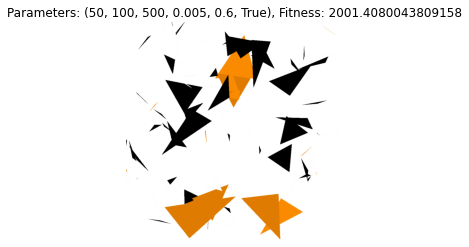

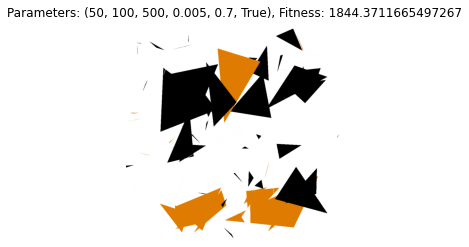

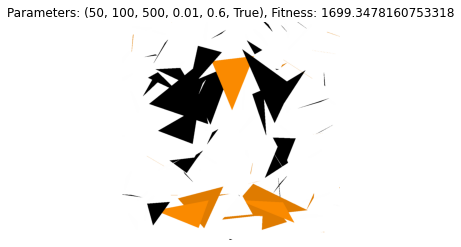

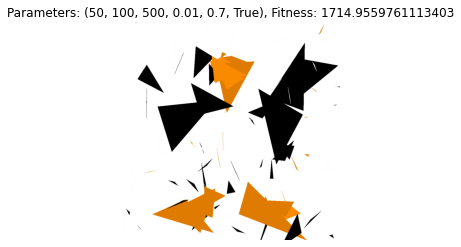

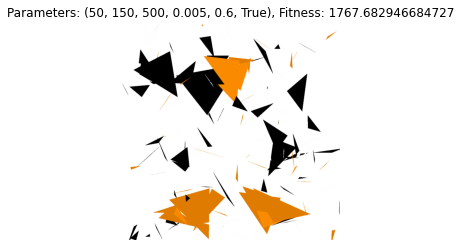

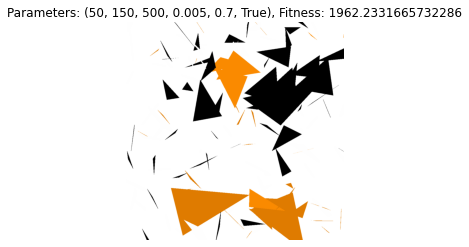

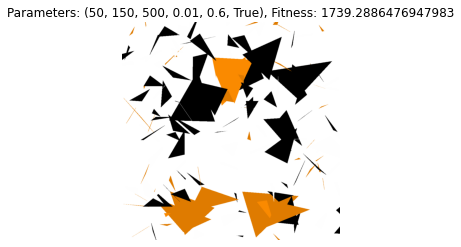

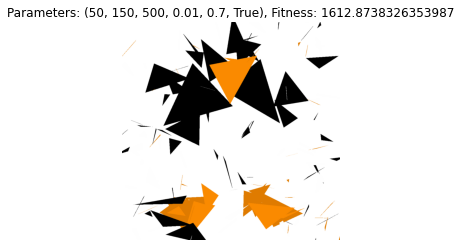

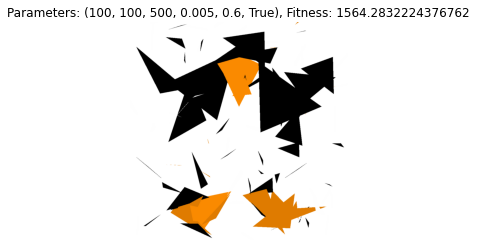

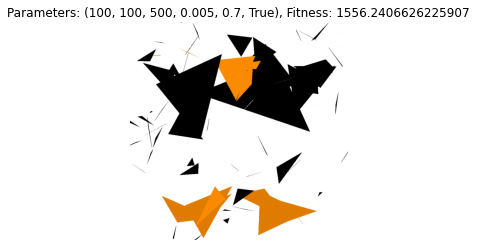

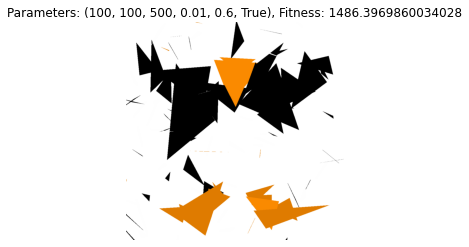

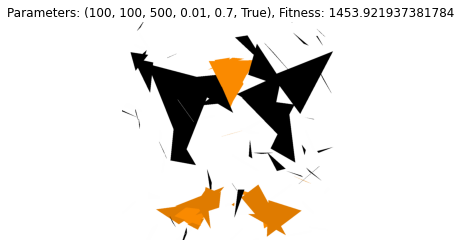

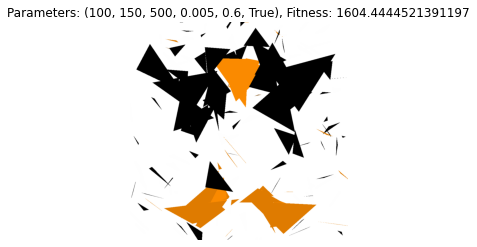

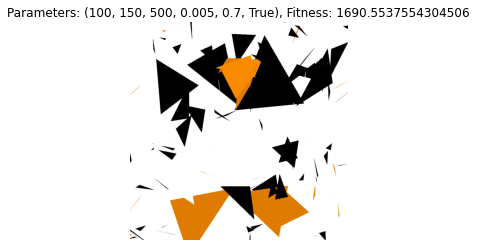

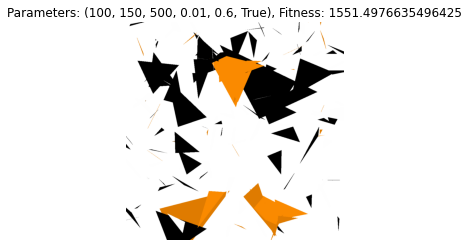

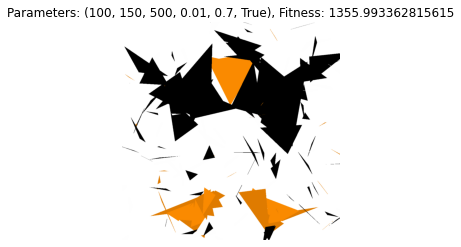

Best Parameters: (50, 100, 500, 0.005, 0.6, True), Best Fitness: 2001.4080043809158


In [4]:
import itertools
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define parameter grid
param_grid = {
    'population_size': [50, 100],
    'num_triangles': [100, 150],
    'generations': [500],
    'mutation_rate': [0.005, 0.01],
    'crossover_prob': [0.6, 0.7],
    'elitism': [True]
}

# Create all combinations of parameters
param_combinations = list(itertools.product(*param_grid.values()))

target_image_path = 'target_image.png'
target_image = Image.open(target_image_path).convert('RGB')
img_width, img_height = target_image.size

color_extractor = Color(target_image_path, num_colors=10)
palette = color_extractor.palette

# Function to evaluate a set of parameters
def evaluate_params(params):
    population_size, num_triangles, generations, mutation_rate, crossover_prob, elitism = params
    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)
    
    # Assuming population has attributes individuals and fitness
    best_index = population.fitness.index(min(population.fitness))  # or max() depending on the optimization
    best_individual = population.individuals[best_index]
    return population.fitness[best_index], best_individual

# Perform grid search
results = []
for params in param_combinations:
    fitness, best_individual = evaluate_params(params)
    results.append((params, fitness, best_individual))
    print(f"Parameters: {params}, Fitness: {fitness}")

# Display images for each parameter combination
for params, fitness, best_individual in results:
    best_image = best_individual.draw()
    best_image_array = np.array(best_image)
    plt.imshow(best_image_array)
    plt.title(f"Parameters: {params}, Fitness: {fitness}")
    plt.axis('off')  
    plt.show()

# Find the best parameters
best_params, best_fitness, best_individual = max(results, key=lambda x: x[1])
print(f"Best Parameters: {best_params}, Best Fitness: {best_fitness}")

After analysing the 16 different combinations, we decided to choose between the 2 best to see which one gave us the better results. For that, we will use the same approach as we did when testing for the crossover and the fitness function, this meaning, we will run 5 times each combination of parameters.

## Combination 1 

Parameters = (100, 150, 500, 0.01, 0.7)

We ran this code 5 times even thought we only have the output of the last run. All the fitnes_values were saved into a text file.

In [4]:
population_size = 100
num_triangles = 150
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

fitness_file = "fitness_values_combination1.txt"

for run in range(2):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 1
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [ 85  85  85]
 [181 181 181]
 [119  66   0]
 [ 41  36  30]
 [222 222 222]
 [135 135 135]
 [223 123   0]]
Generation 1, Best Fitness: 5237.4753460040265
Generation 2, Best Fitness: 5099.173462434868
Generation 3, Best Fitness: 4980.130620776929
Generation 4, Best Fitness: 4963.436208918172
Generation 5, Best Fitness: 4816.523123581989
Generation 6, Best Fitness: 4780.389628471721
Generation 7, Best Fitness: 4594.550467673633
Generation 8, Best Fitness: 4594.550467673633
Generation 9, Best Fitness: 4496.178710861035
Generation 10, Best Fitness: 4345.3042471154995
Generation 11, Best Fitness: 4281.589190943007
Generation 12, Best Fitness: 4259.79799990563
Generation 13, Best Fitness: 4165.654450383517
Generation 14, Best Fitness: 4114.706672412993
Generation 15, Best Fitness: 4102.809525191244
Generation 16, Best Fitness: 4034.12915013885
Generation 17, Best Fitness: 4014.936612201991
Generation 18, Best Fitness: 3996.

Generation 169, Best Fitness: 2077.6883789442536
Generation 170, Best Fitness: 2074.285178079427
Generation 171, Best Fitness: 2073.0663279306814
Generation 172, Best Fitness: 2067.2907391075887
Generation 173, Best Fitness: 2066.8091348743355
Generation 174, Best Fitness: 2064.842124715592
Generation 175, Best Fitness: 2051.3073879845506
Generation 176, Best Fitness: 2049.9821950446303
Generation 177, Best Fitness: 2048.784761755124
Generation 178, Best Fitness: 2045.6092002139608
Generation 179, Best Fitness: 2045.6092002139608
Generation 180, Best Fitness: 2036.2229740379612
Generation 181, Best Fitness: 2036.2229740379612
Generation 182, Best Fitness: 2030.5176679851866
Generation 183, Best Fitness: 2028.4501472799375
Generation 184, Best Fitness: 2026.637362726741
Generation 185, Best Fitness: 2021.5214567251073
Generation 186, Best Fitness: 2013.660597022249
Generation 187, Best Fitness: 1973.1457118013357
Generation 188, Best Fitness: 1969.2074547898706
Generation 189, Best Fitn

Generation 338, Best Fitness: 1616.817243846688
Generation 339, Best Fitness: 1616.817243846688
Generation 340, Best Fitness: 1616.817243846688
Generation 341, Best Fitness: 1615.9845296289195
Generation 342, Best Fitness: 1615.9845296289195
Generation 343, Best Fitness: 1614.2186964596835
Generation 344, Best Fitness: 1614.2186964596835
Generation 345, Best Fitness: 1612.6317000480922
Generation 346, Best Fitness: 1610.1608615290586
Generation 347, Best Fitness: 1609.6415750097908
Generation 348, Best Fitness: 1606.2745717964908
Generation 349, Best Fitness: 1606.2745717964908
Generation 350, Best Fitness: 1602.5663792804341
Generation 351, Best Fitness: 1601.6532084068635
Generation 352, Best Fitness: 1597.4914710257453
Generation 353, Best Fitness: 1596.7441874013507
Generation 354, Best Fitness: 1592.6173426156076
Generation 355, Best Fitness: 1592.6173426156076
Generation 356, Best Fitness: 1592.6173426156076
Generation 357, Best Fitness: 1592.6173426156076
Generation 358, Best Fi

Generation 3, Best Fitness: 4923.711912774751
Generation 4, Best Fitness: 4873.5631728746475
Generation 5, Best Fitness: 4794.118897148881
Generation 6, Best Fitness: 4668.967337645446
Generation 7, Best Fitness: 4542.296555708356
Generation 8, Best Fitness: 4504.998335182822
Generation 9, Best Fitness: 4424.077870019921
Generation 10, Best Fitness: 4424.077870019921
Generation 11, Best Fitness: 4287.382884697843
Generation 12, Best Fitness: 4154.069811642554
Generation 13, Best Fitness: 4131.570282592322
Generation 14, Best Fitness: 4102.405757601264
Generation 15, Best Fitness: 4090.0658918897625
Generation 16, Best Fitness: 4018.077276509251
Generation 17, Best Fitness: 3979.962939525945
Generation 18, Best Fitness: 3971.833455722936
Generation 19, Best Fitness: 3938.5967044113568
Generation 20, Best Fitness: 3898.875478904142
Generation 21, Best Fitness: 3898.875478904142
Generation 22, Best Fitness: 3848.045218029539
Generation 23, Best Fitness: 3804.907620429174
Generation 24, Be

Generation 175, Best Fitness: 2153.9231648320233
Generation 176, Best Fitness: 2148.479229594738
Generation 177, Best Fitness: 2128.8990112262254
Generation 178, Best Fitness: 2128.7562096210077
Generation 179, Best Fitness: 2128.7562096210077
Generation 180, Best Fitness: 2121.434184696758
Generation 181, Best Fitness: 2089.751899149753
Generation 182, Best Fitness: 2085.12038021789
Generation 183, Best Fitness: 2085.12038021789
Generation 184, Best Fitness: 2083.6396041542307
Generation 185, Best Fitness: 2083.6396041542307
Generation 186, Best Fitness: 2080.8058535096443
Generation 187, Best Fitness: 2078.277652288067
Generation 188, Best Fitness: 2070.7119548599703
Generation 189, Best Fitness: 2070.7119548599703
Generation 190, Best Fitness: 2066.0300094625923
Generation 191, Best Fitness: 2059.579325978973
Generation 192, Best Fitness: 2053.338257569853
Generation 193, Best Fitness: 2052.3194195836086
Generation 194, Best Fitness: 2046.6032834919424
Generation 195, Best Fitness: 

Generation 344, Best Fitness: 1653.7663075537607
Generation 345, Best Fitness: 1649.2116298401488
Generation 346, Best Fitness: 1649.2116298401488
Generation 347, Best Fitness: 1649.2116298401488
Generation 348, Best Fitness: 1643.706786504211
Generation 349, Best Fitness: 1643.706786504211
Generation 350, Best Fitness: 1642.4475638509741
Generation 351, Best Fitness: 1639.5868382004046
Generation 352, Best Fitness: 1639.5868382004046
Generation 353, Best Fitness: 1637.9239909104451
Generation 354, Best Fitness: 1637.9239909104451
Generation 355, Best Fitness: 1636.813367491847
Generation 356, Best Fitness: 1635.263587315513
Generation 357, Best Fitness: 1635.263587315513
Generation 358, Best Fitness: 1635.263587315513
Generation 359, Best Fitness: 1631.7291441902973
Generation 360, Best Fitness: 1631.7291441902973
Generation 361, Best Fitness: 1631.3013210317706
Generation 362, Best Fitness: 1631.3013210317706
Generation 363, Best Fitness: 1625.989852366859
Generation 364, Best Fitnes

# Combination 2 

Parameters = (100, 100, 500, 0.01, 0.7)

We ran this code 5 times even though we only have the output of the last run. All the fitness_values where saved into a text file.

In [4]:
population_size = 100
num_triangles = 100
generations = 500
mutation_rate = 0.01
crossover_prob = 0.7
elitism = True

fitness_file = "fitness_values_combination2.txt"

for run in range(1):
    print(f"Run {run + 1}")
    
    target_image_path = 'target_image.png'
    target_image = Image.open(target_image_path).convert('RGB')
    img_width, img_height = target_image.size

    color_extractor = Color(target_image_path, num_colors=10)
    palette = color_extractor.palette

    population = Population(size=population_size, img_width=img_width, img_height=img_height, num_triangles=num_triangles, target_image=target_image, palette=palette)
    population.evolve(gens=generations, xo_prob=crossover_prob, mut_prob=mutation_rate, elitism=elitism)

    with open(fitness_file, "a") as file:
        for fitness in population.fitness_history:
            file.write(f"{fitness}\n")

Run 1
Extracted palette: [[254 254 254]
 [  0   0   0]
 [250 138   0]
 [146 146 146]
 [123  68   0]
 [186 186 186]
 [ 69  69  69]
 [224 224 224]
 [ 36  30  23]
 [107 107 107]]
Generation 1, Best Fitness: 4829.5782424555455
Generation 2, Best Fitness: 4750.952430829002
Generation 3, Best Fitness: 4632.907402484967
Generation 4, Best Fitness: 4493.227236630705
Generation 5, Best Fitness: 4293.239452907326
Generation 6, Best Fitness: 4247.6940803216985
Generation 7, Best Fitness: 4138.486317483725
Generation 8, Best Fitness: 4138.486317483725
Generation 9, Best Fitness: 4138.486317483725
Generation 10, Best Fitness: 4115.626683750605
Generation 11, Best Fitness: 4041.8999245404384
Generation 12, Best Fitness: 4040.4694034233203
Generation 13, Best Fitness: 3963.8376606516063
Generation 14, Best Fitness: 3919.2500558142497
Generation 15, Best Fitness: 3871.9590648662597
Generation 16, Best Fitness: 3871.9590648662597
Generation 17, Best Fitness: 3848.4013564076186
Generation 18, Best Fitne

Generation 169, Best Fitness: 2313.190653621097
Generation 170, Best Fitness: 2302.4893050783103
Generation 171, Best Fitness: 2298.8851645960917
Generation 172, Best Fitness: 2288.361859496876
Generation 173, Best Fitness: 2251.9225119883677
Generation 174, Best Fitness: 2251.9225119883677
Generation 175, Best Fitness: 2249.625746652096
Generation 176, Best Fitness: 2202.8649527376842
Generation 177, Best Fitness: 2196.011611991157
Generation 178, Best Fitness: 2196.011611991157
Generation 179, Best Fitness: 2195.2437222322264
Generation 180, Best Fitness: 2181.173078872926
Generation 181, Best Fitness: 2178.9706285308207
Generation 182, Best Fitness: 2178.9706285308207
Generation 183, Best Fitness: 2176.4964966661446
Generation 184, Best Fitness: 2161.4428051651053
Generation 185, Best Fitness: 2155.89169486781
Generation 186, Best Fitness: 2149.87604293829
Generation 187, Best Fitness: 2145.3193235506924
Generation 188, Best Fitness: 2138.584812440227
Generation 189, Best Fitness: 2

Generation 338, Best Fitness: 1734.6002421307337
Generation 339, Best Fitness: 1733.8200598678054
Generation 340, Best Fitness: 1733.8200598678054
Generation 341, Best Fitness: 1732.593720408798
Generation 342, Best Fitness: 1732.0178982908924
Generation 343, Best Fitness: 1731.4661417423097
Generation 344, Best Fitness: 1730.1436356557222
Generation 345, Best Fitness: 1730.1141580832173
Generation 346, Best Fitness: 1730.0479762133766
Generation 347, Best Fitness: 1729.0809697639957
Generation 348, Best Fitness: 1729.0809697639957
Generation 349, Best Fitness: 1728.6133170839566
Generation 350, Best Fitness: 1728.049189114708
Generation 351, Best Fitness: 1727.4249621908327
Generation 352, Best Fitness: 1726.8700008975777
Generation 353, Best Fitness: 1725.962919648044
Generation 354, Best Fitness: 1725.3518481747426
Generation 355, Best Fitness: 1712.5983183455483
Generation 356, Best Fitness: 1712.0954996728424
Generation 357, Best Fitness: 1711.0955554848479
Generation 358, Best Fi

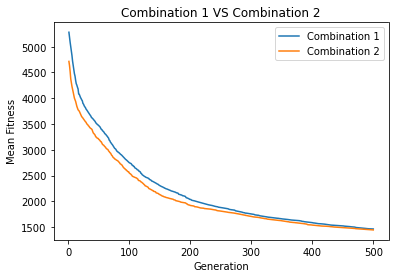

In [7]:
def process_fitness_file(filename, normalize=False):
    with open(filename, "r") as file:
        fitness_values = [float(line.strip()) for line in file]

    num_generations_per_run = 500
    num_runs = len(fitness_values) // num_generations_per_run

    fitness_values = np.array(fitness_values)
    fitness_values = fitness_values.reshape(num_runs, num_generations_per_run)

    if normalize:
        min_value = np.min(fitness_values)
        max_value = np.max(fitness_values)
        fitness_values = (fitness_values - min_value) / (max_value - min_value)
    
    mean_fitness_per_generation = np.mean(fitness_values, axis=0)
    
    return mean_fitness_per_generation

mean_fitness_comb1 = process_fitness_file("fitness_values_combination1.txt")
mean_fitness_comb2 = process_fitness_file("fitness_values_combination2.txt")

plt.plot(range(1, 501), mean_fitness_comb1, label='Combination 1')
plt.plot(range(1, 501), mean_fitness_comb2, label='Combination 2')
plt.xlabel('Generation')
plt.ylabel('Mean Fitness')
plt.title('Combination 1 VS Combination 2')
plt.legend()
plt.show()